In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import seaborn as sns


/home/mehrab/Repositories/Cogni-E-Spin/analysis/inverse_design/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../data/PVA-Ziabari-2009.csv")
df.head()

,concentration,distance,voltage,flow_rate,diameter,diameter_stdev
0,8,10.0,15.0,0.2,232.62,26.60
1,8,10.0,15.0,0.3,235.50,24.52
2,8,10.0,15.0,0.4,252.02,25.89
3,8,10.0,20.0,0.2,236.84,37.30
4,8,10.0,20.0,0.3,232.08,30.22


In [4]:
X = df[["concentration", "distance", "voltage", "flow_rate"]]
y = df['diameter']

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_shap_vals = []
all_X_valid   = []
feature_names = X.columns

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):
    print(f"Training fold {fold} ...")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # Train XGBoost
    model = XGBRegressor(
        n_estimators=50,
        learning_rate=0.2,
        max_depth=3,
        subsample=0.6,
        colsample_bytree=1.0,
        random_state=42
    )

    model.fit(X_train, y_train)

    # SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_valid)

    all_shap_vals.append(shap_values)
    all_X_valid.append(X_valid)

print("All folds complete.\n")

Training fold 1 ...
Training fold 2 ...
Training fold 3 ...
Training fold 4 ...
Training fold 5 ...
All folds complete.



In [6]:
shap_values_all = np.vstack(all_shap_vals)
X_all_valid     = pd.concat(all_X_valid)


In [7]:
mean_abs_shap = np.abs(shap_values_all).mean(axis=0)
importance_order = feature_names[np.argsort(mean_abs_shap)][::-1]  # descending



In [8]:
new_names = {
    'voltage': 'Voltage (kV)',
    'flow_rate': 'Flow rate (mL/h)',
    'distance': 'Tip-Collector Distance (cm)',
    'concentration': 'Concentration (wt%)'
}

X_all_valid_renamed = X_all_valid.rename(columns=new_names)


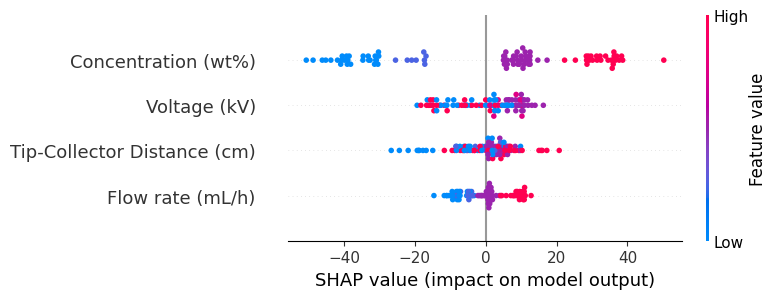

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,4))

shap.summary_plot(
    shap_values_all,
    X_all_valid_renamed,
    max_display=4,
    plot_type="dot",
    color=plt.get_cmap("viridis"),
    show=False # Prevents SHAP from automatically calling plt.show()
)

plt.xlabel("SHAP value (impact on predicted nanofibre diameter)") # <-- CRITICAL ADDITION
plt.tight_layout()
plt.savefig("shap_nanofibre_diameter.png", dpi=300)
plt.show()